In [2]:
import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html

Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html


A single neural network (NeRF model)
is trained to represent a single 3D scene

In [3]:
import torch
import matplotlib.pyplot as plt
from pytorch3d.renderer import (FoVPerspectiveCameras,NDCMultinomialRaysampler,
                                MonteCarloRaysampler,EmissionAbsorptionRaymarcher,
                                ImplicitRenderer,)


In [4]:
from utils.helper_functions import generate_rotating_nerf,huber,sample_images_at_mc_locs
from nerf_model import NeuralRadianceField
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  print('使用cpu')
  device = torch.device('cpu')


In [5]:
# 使用幫助函數來產生訓練圖片
from utils.plot_image_grid import image_grid
from utils.generate_cow_renders import generate_cow_renders

# 我們現在可以使用這些實用函數來產生攝影機角度、影像和輪廓
# 從多個不同角度的合成牛。 這將列印生成的圖像的數量，
# 輪廓和拍攝角度：
target_cameras,target_images,target_silhouettes = generate_cow_renders(num_views=40,azimuth_range=180)
print(f"產生{len(target_cameras)} 張圖片")

# 正如我們在前一章中所做的那樣，
# 讓我們定義一個光線採樣器。 我們將使用 MonteCarloRaysampler。 這會從影像平面的隨機像素子集產生光線
render_size = target_images.shape[1] *2
volume_extent_world = 3.0
raysampler_mc = MonteCarloRaysampler(
    min_x=-1.0,
    max_x=1.0,
    min_y=-1.0,
    max_y=1.0,
    n_rays_per_image = 750,
    n_pts_per_ray = 128,
    min_depth=0.1,
    max_depth = volume_extent_world,
)
# 定義光線行進器
raymarcher = EmissionAbsorptionRaymarcher()
renderer_mc = ImplicitRenderer(raysampler=raysampler_mc,raymarcher=raymarcher)




產生40 張圖片


。 在訓練模型時，可視化模型輸出總是有用的。 在許多其他中
使用，如果我們看到模型輸出沒有改變，這將幫助我們修正方向
時間。 到目前為止，我們已經使用了 MonteCarloRaysampler，它正在訓練
模型，但是當我們想要渲染完整圖像時這不會有用，因為它是隨機採樣的
射線。 為了查看完整影像，我們需要有系統地取樣與所有像素對應的光線
在輸出幀中。 為了實現這一點，我們將使用 NDCMultinomialRaysampler：

In [6]:
render_size = target_images.shape[1]*2
volume_extent_world = 3.0
raysampler_grid = NDCMultinomialRaysampler(image_height=render_size,image_width=render_size,n_pts_per_ray=128,
                                           min_depth=0.1,max_depth=volume_extent_world)
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid,raymarcher=raymarcher
)


In [7]:
from utils.helper_functions import show_full_render
from nerf_model import  NeuralRadianceField
neural_radiance = NeuralRadianceField()

In [8]:
torch.manual_seed(1)
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)
neural_radiance = neural_radiance.to(device)

In [9]:
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance.parameters(),lr=lr)
batch_size = 6
n_iter = 3000


/content/utils/helper_functions.py:88: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 3, figsize=(15, 10))


Decreasing lr 10-fold


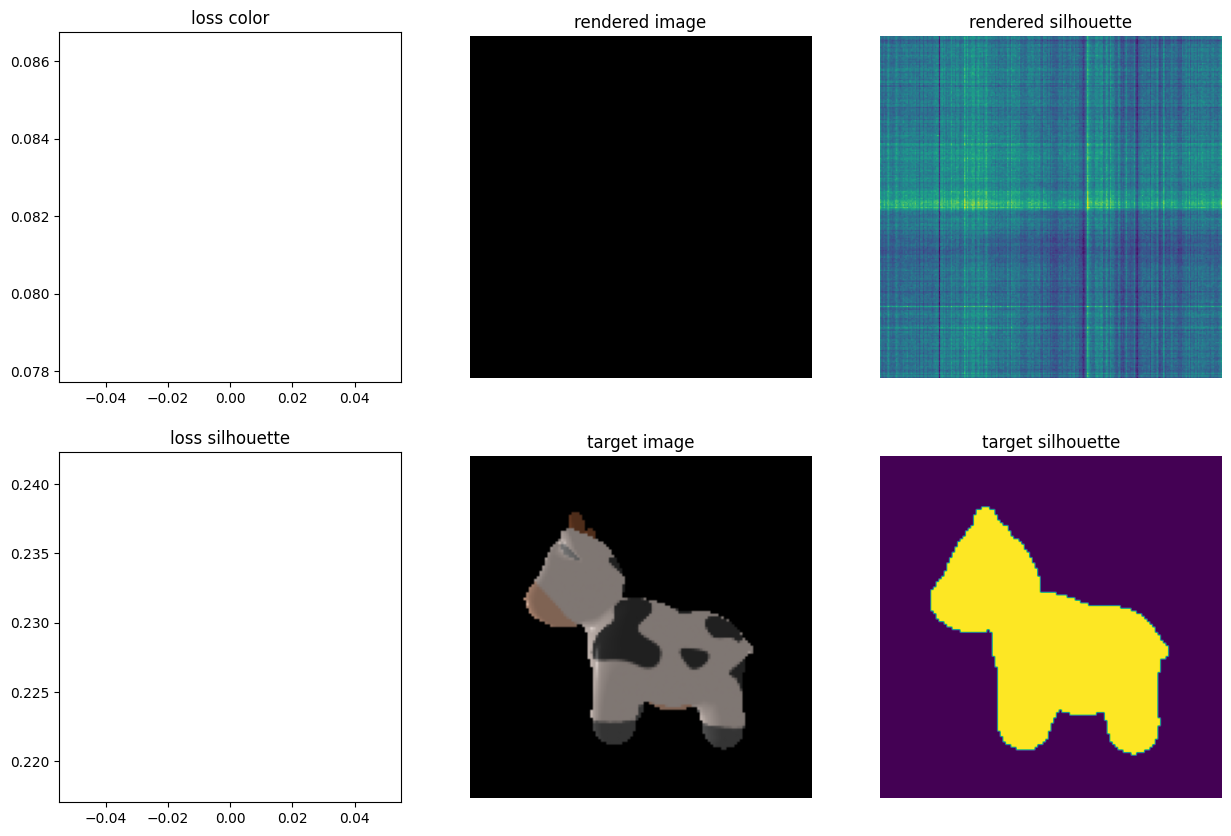

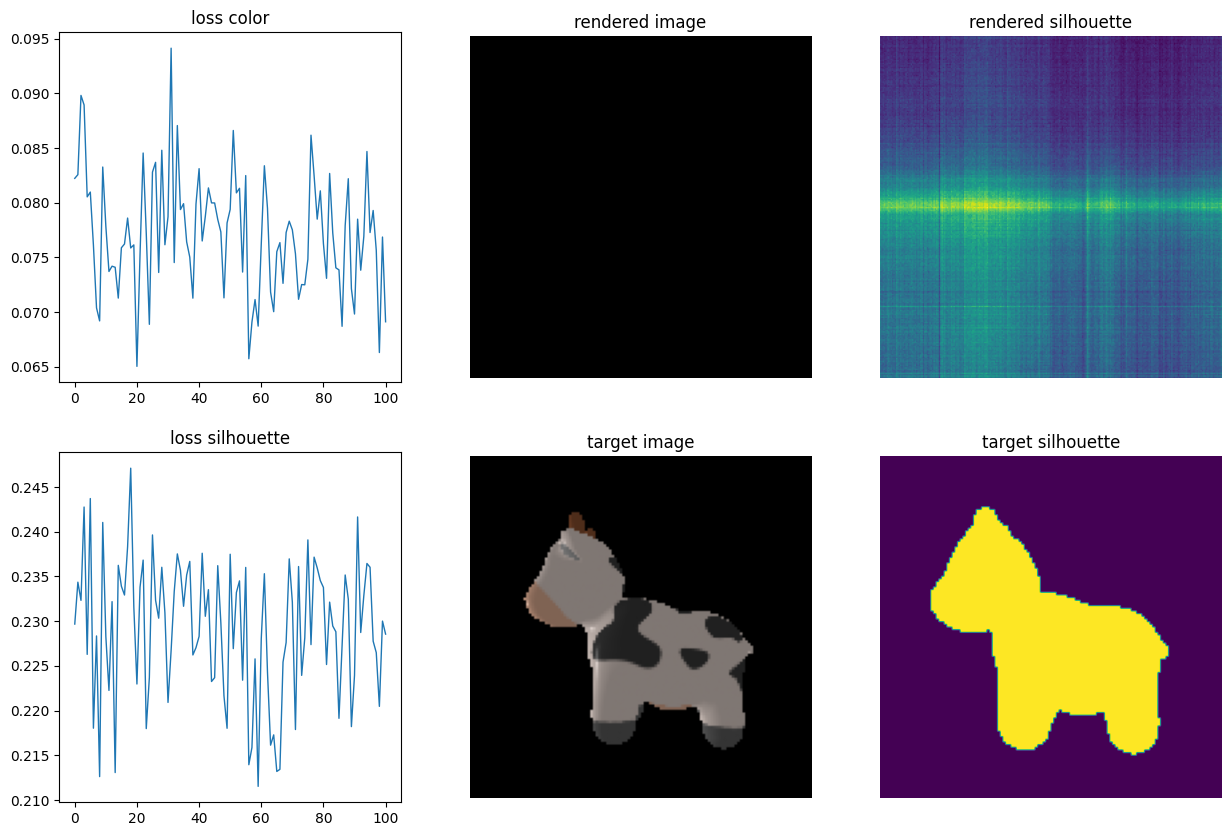

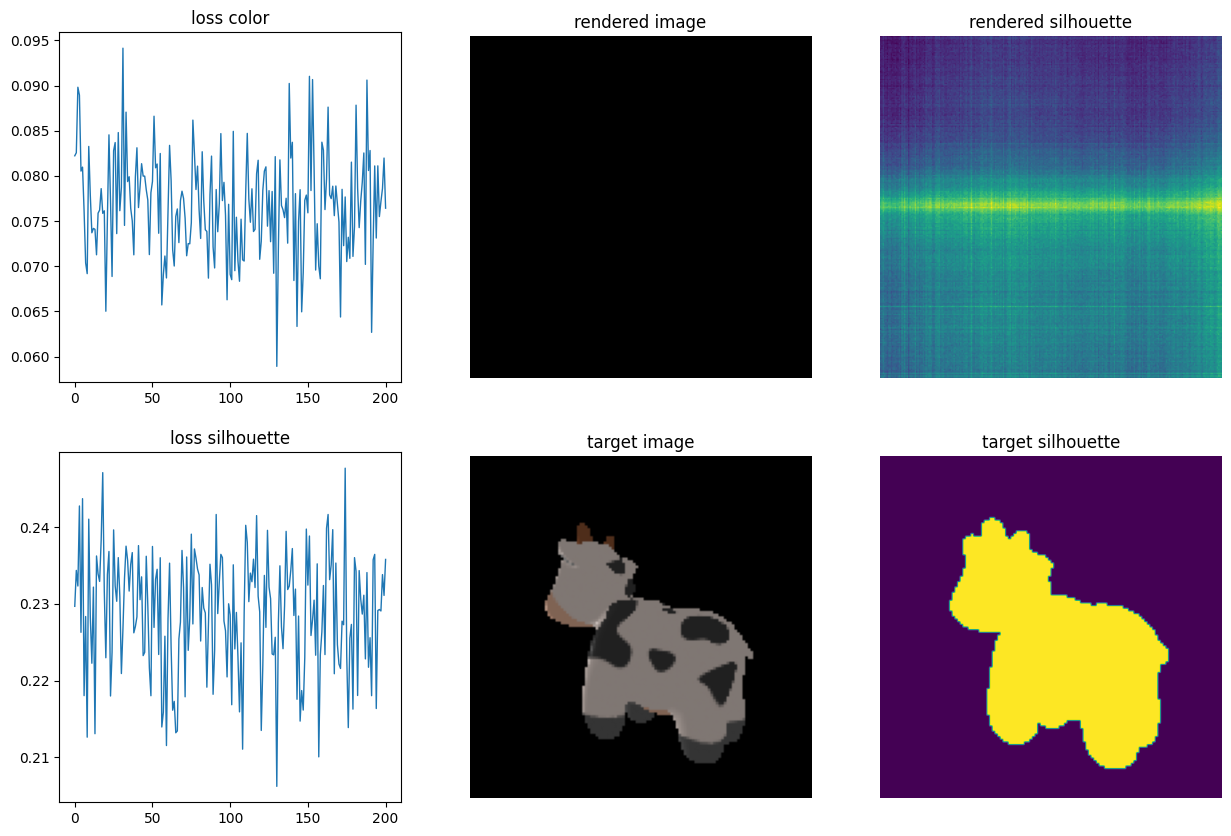

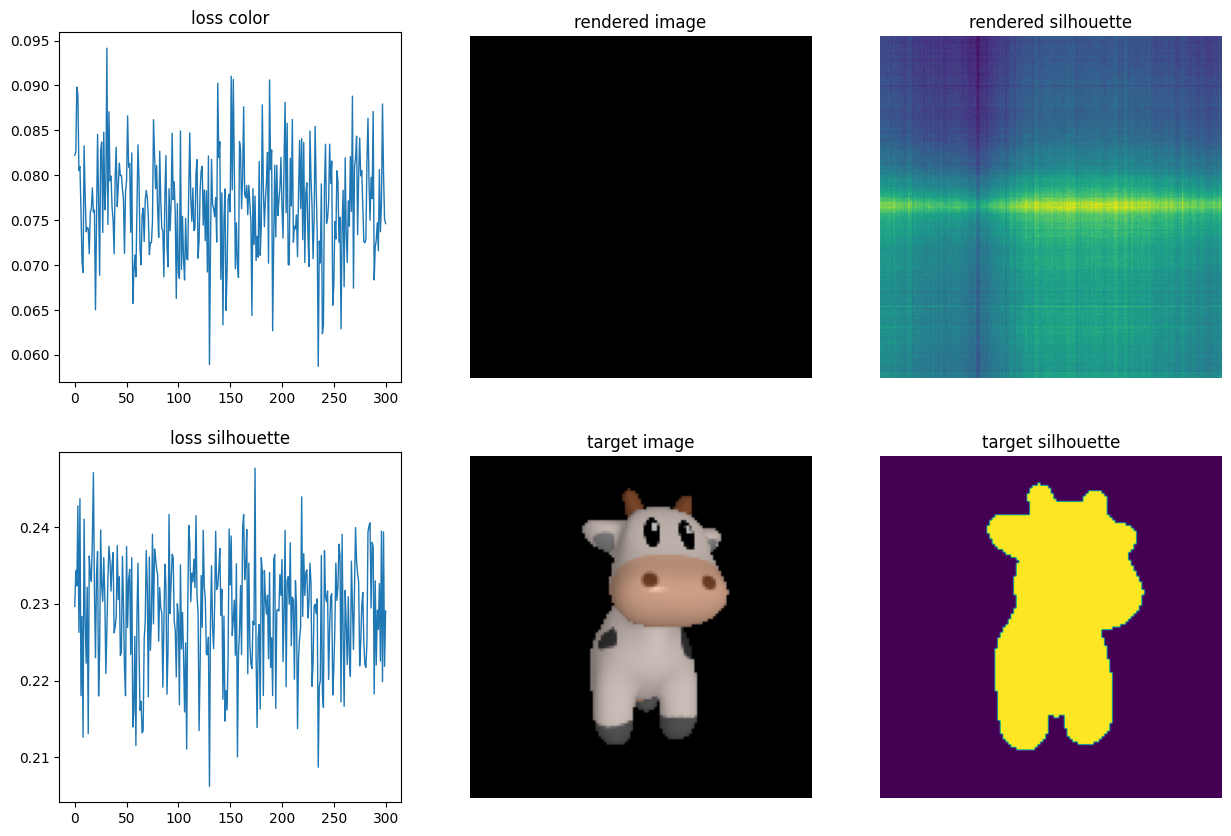

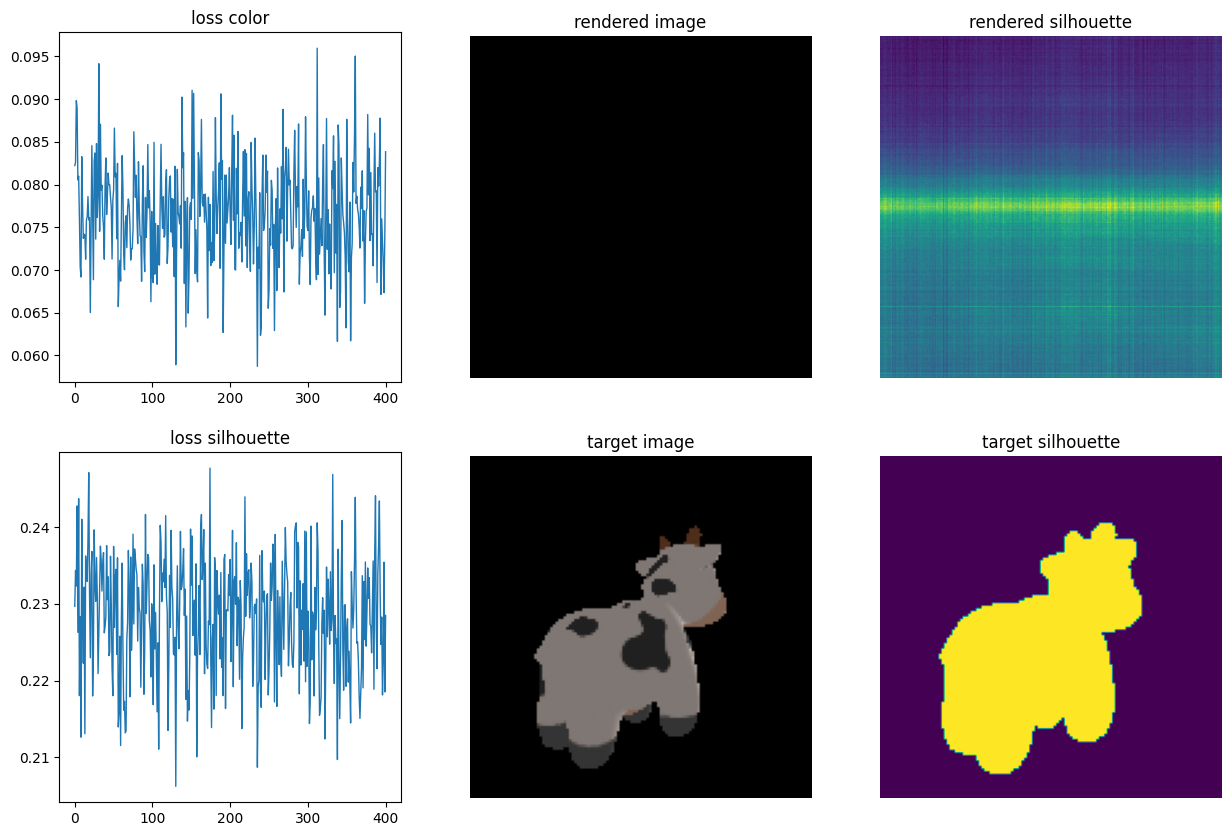

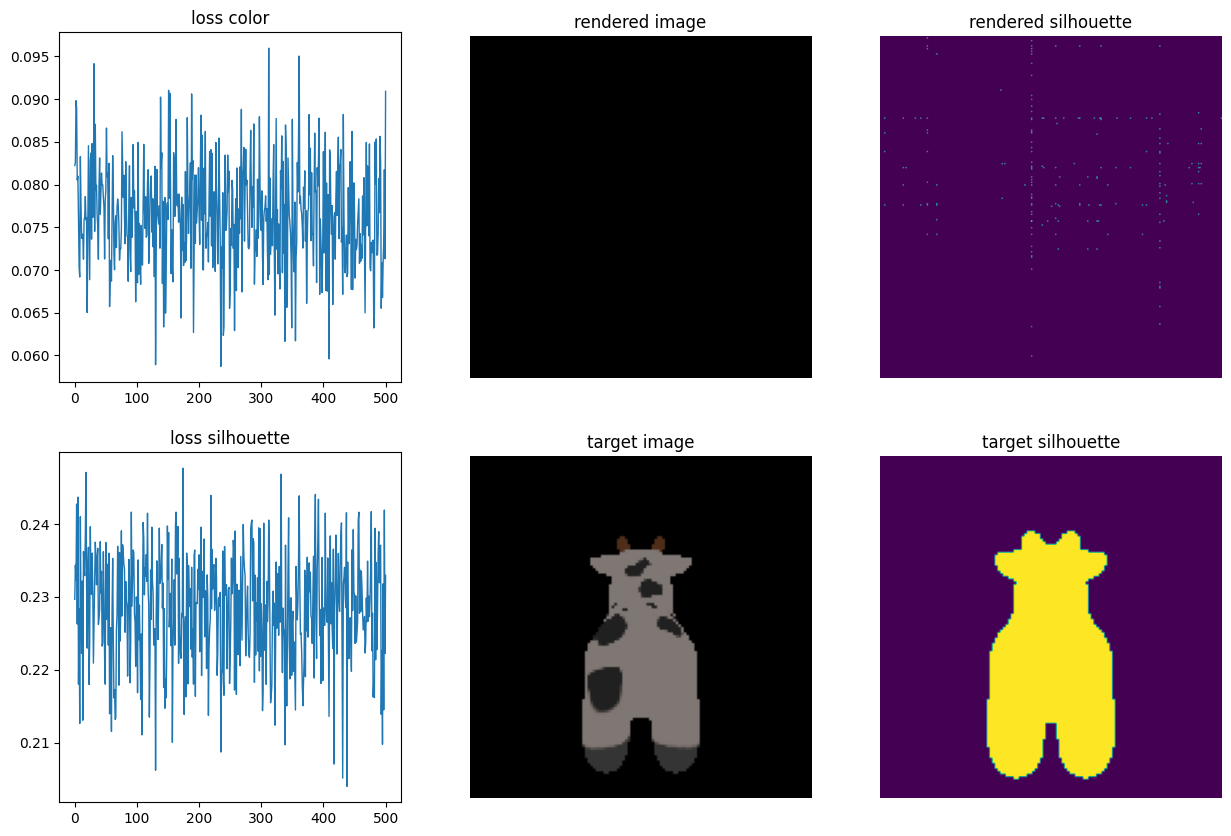

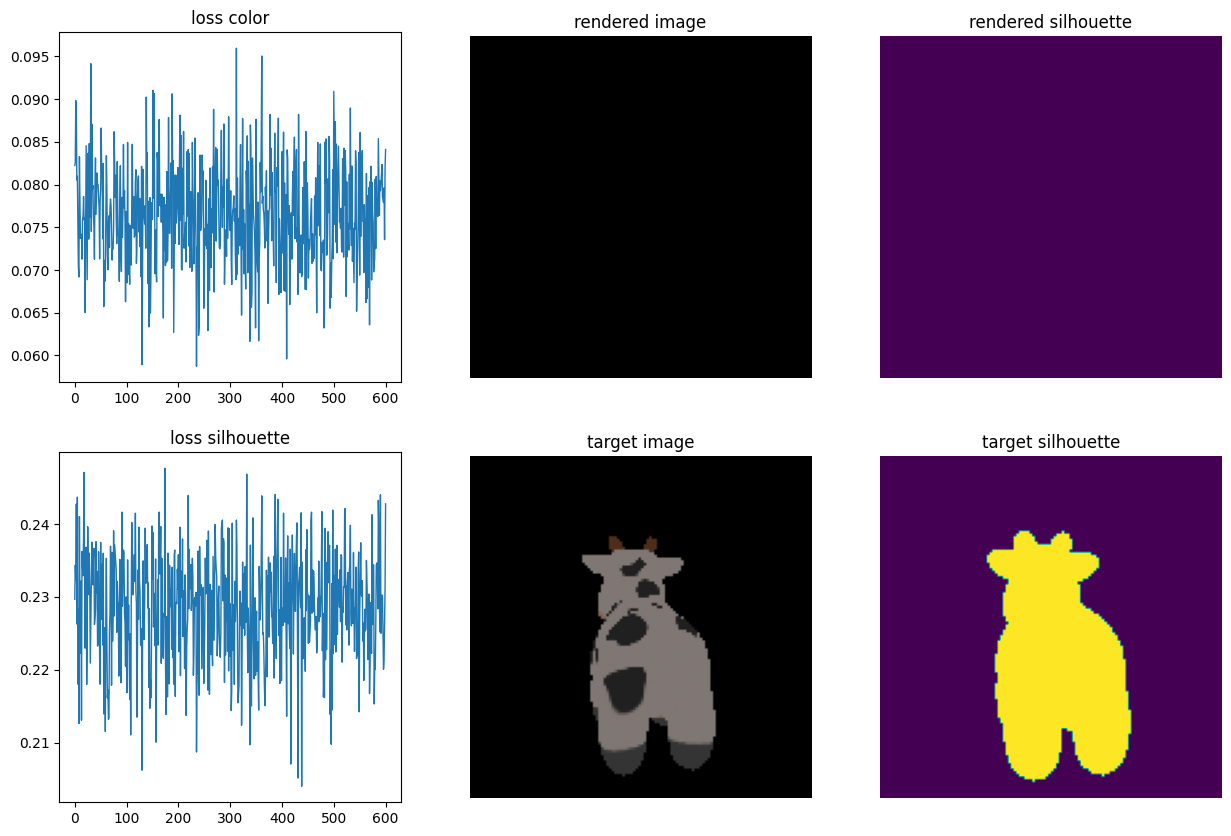

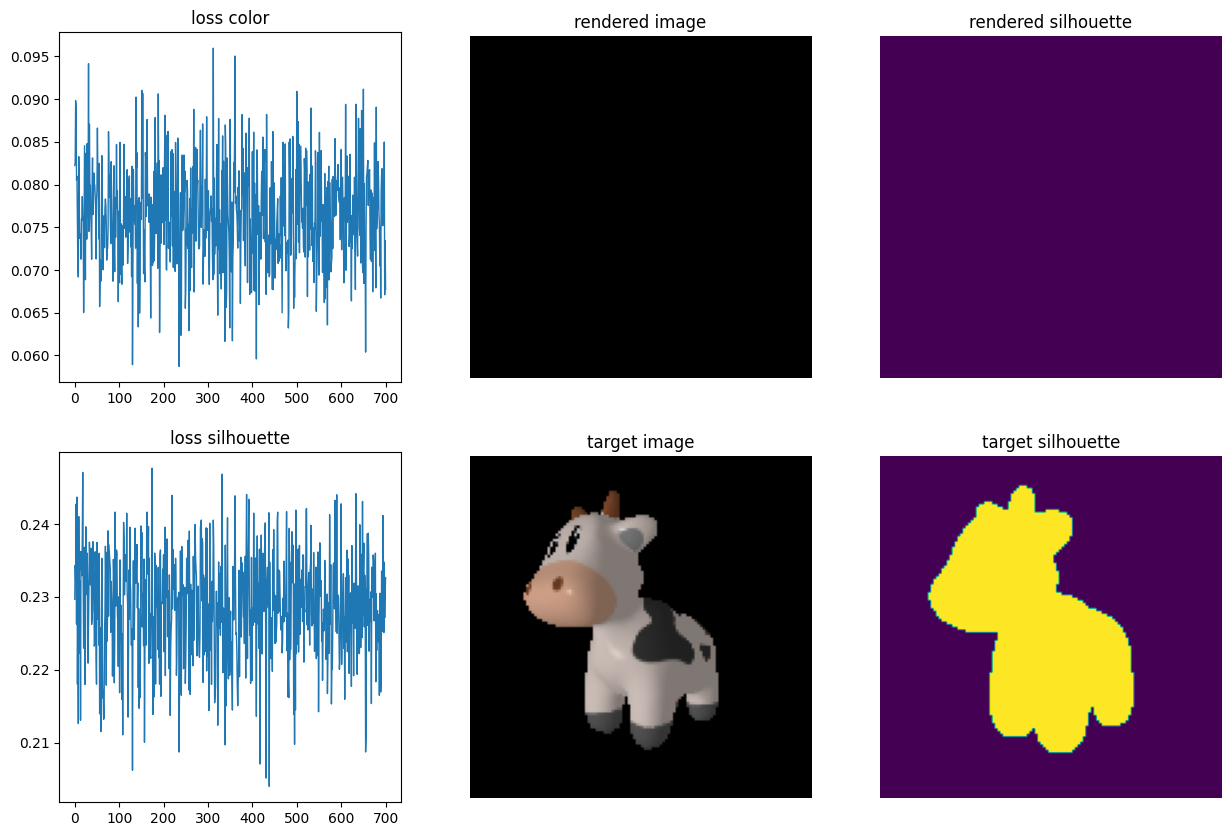

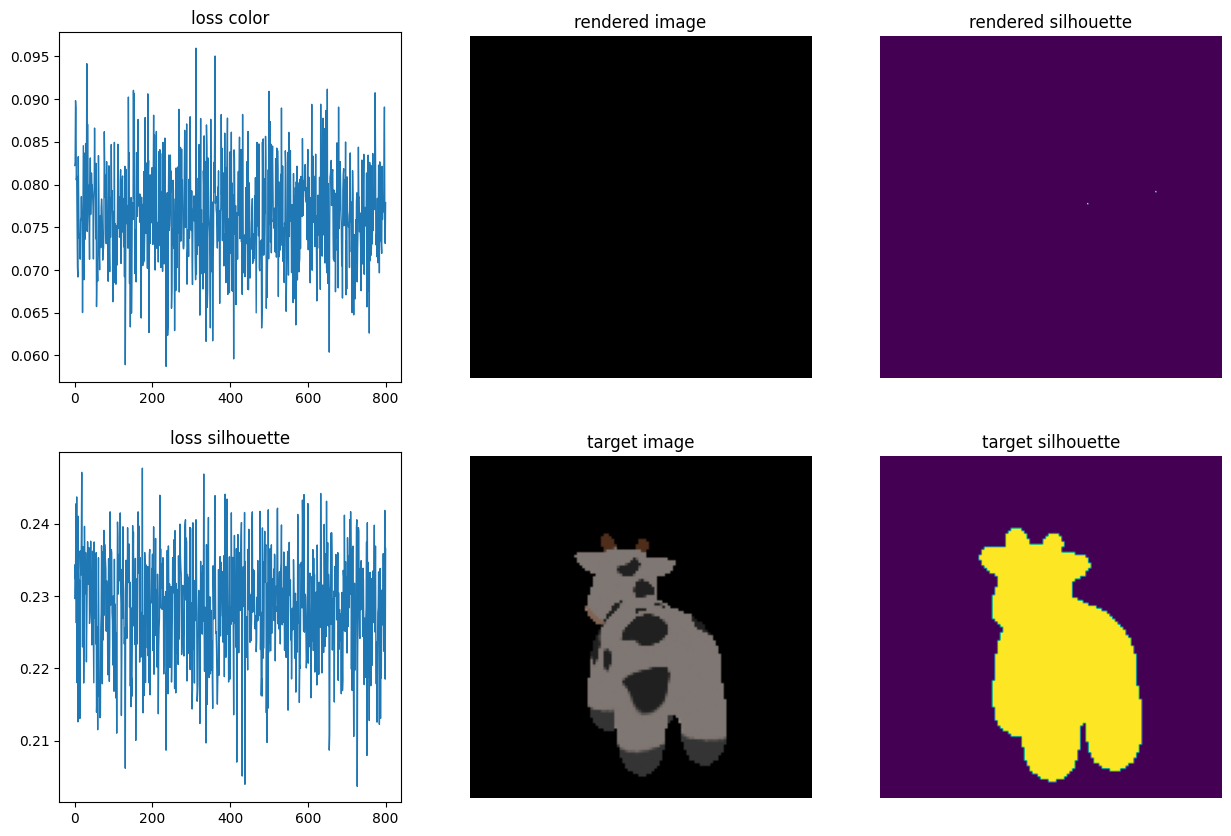

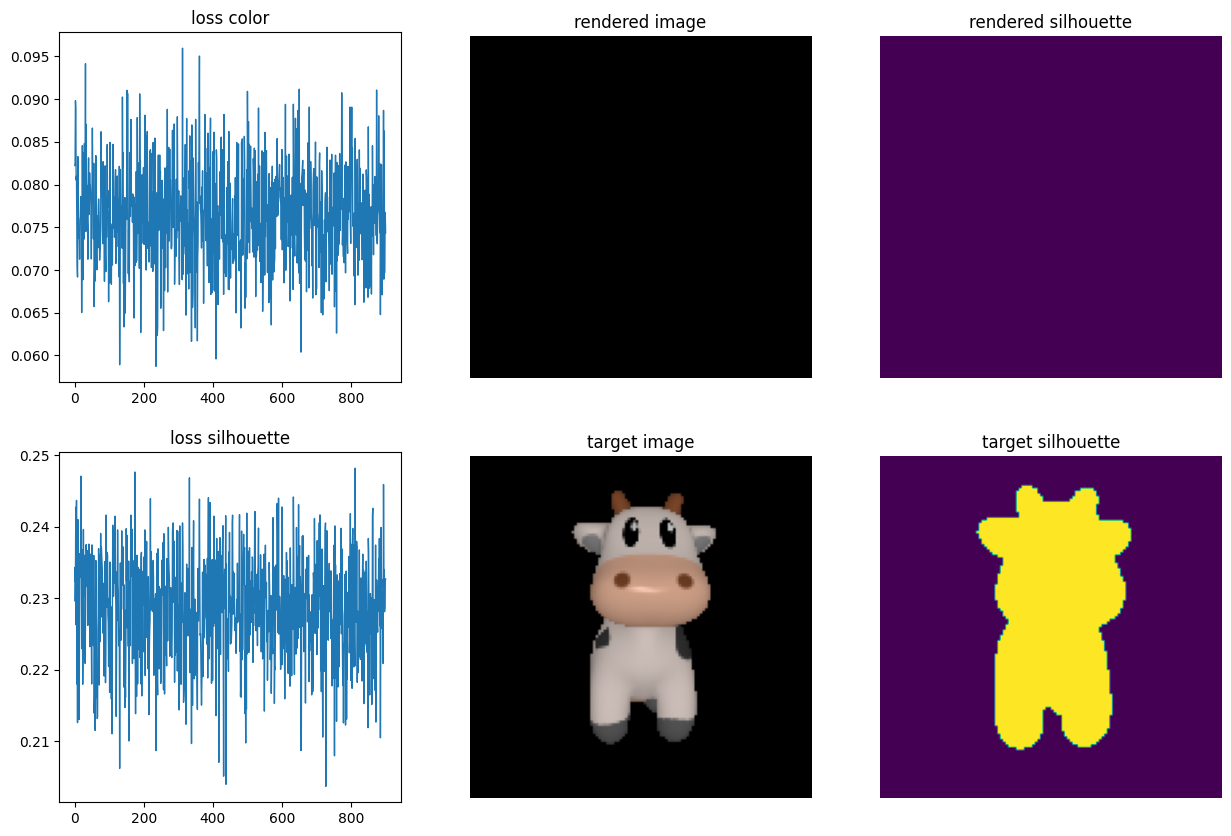

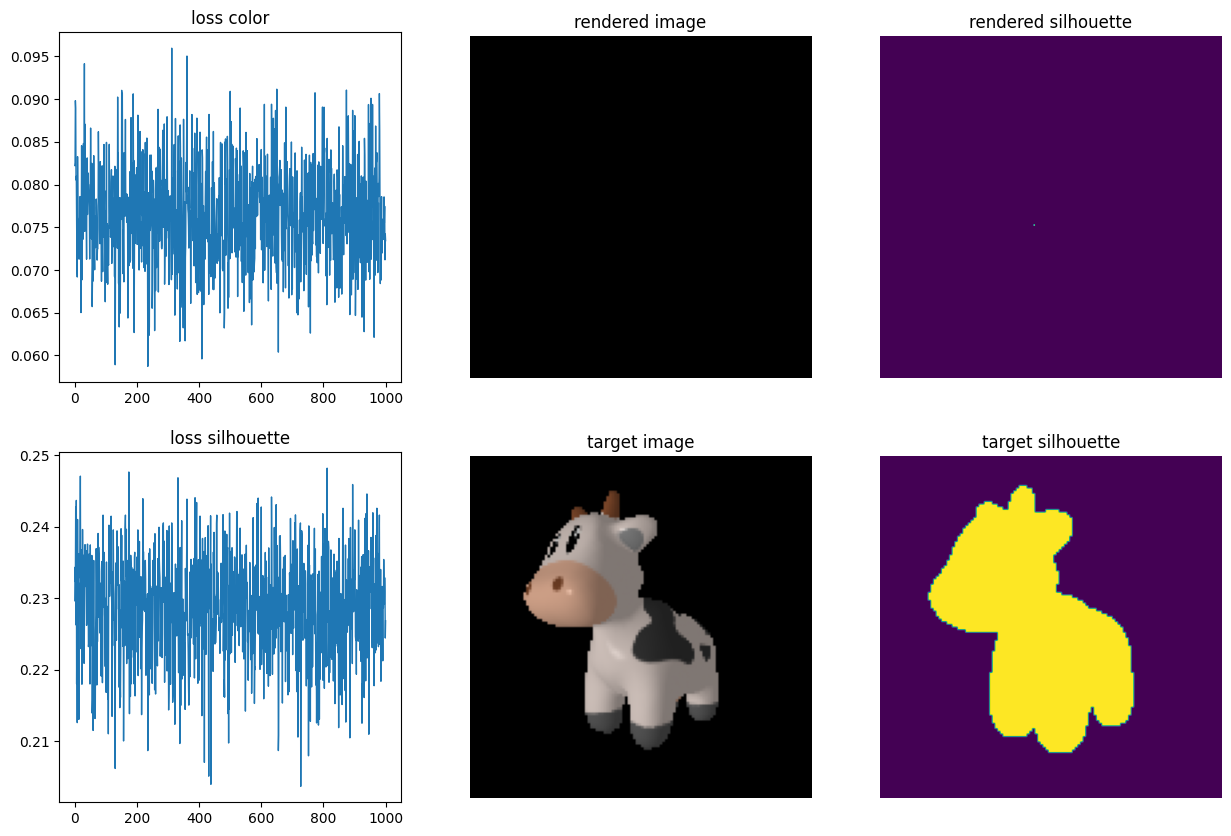

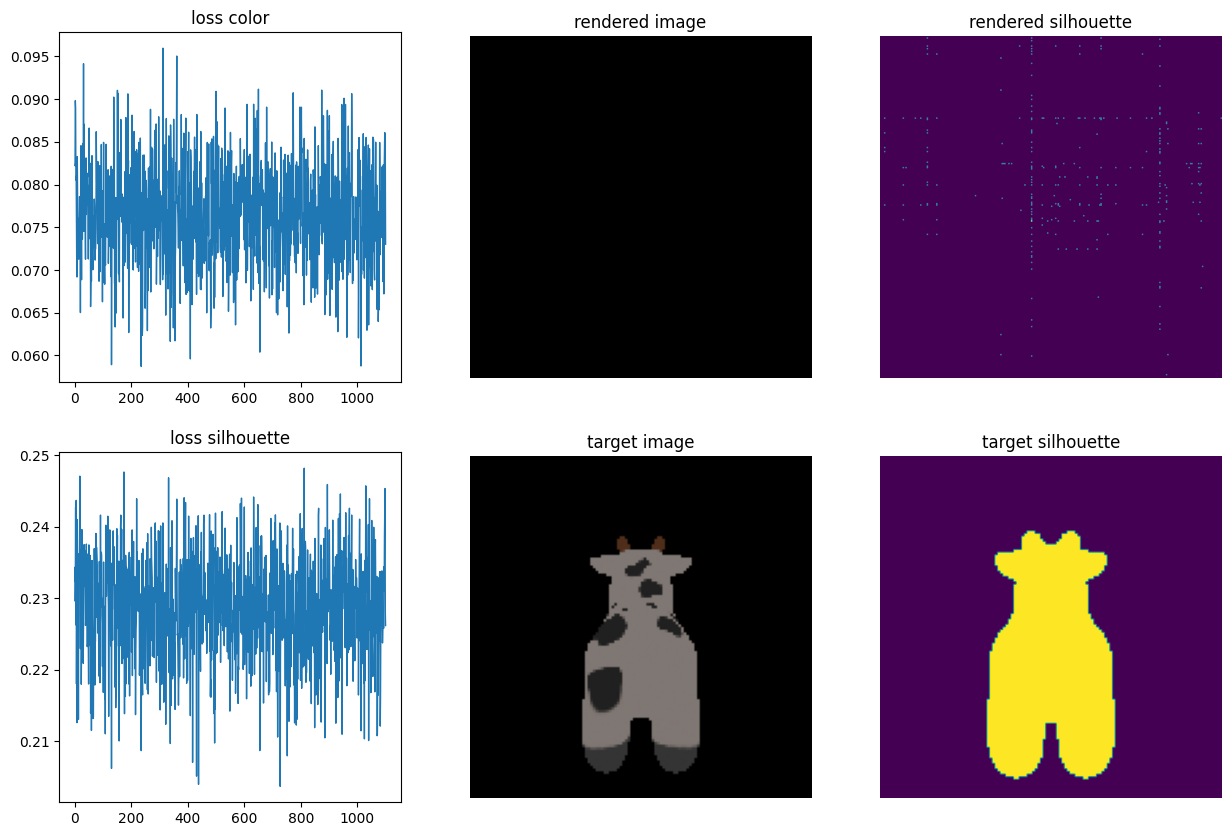

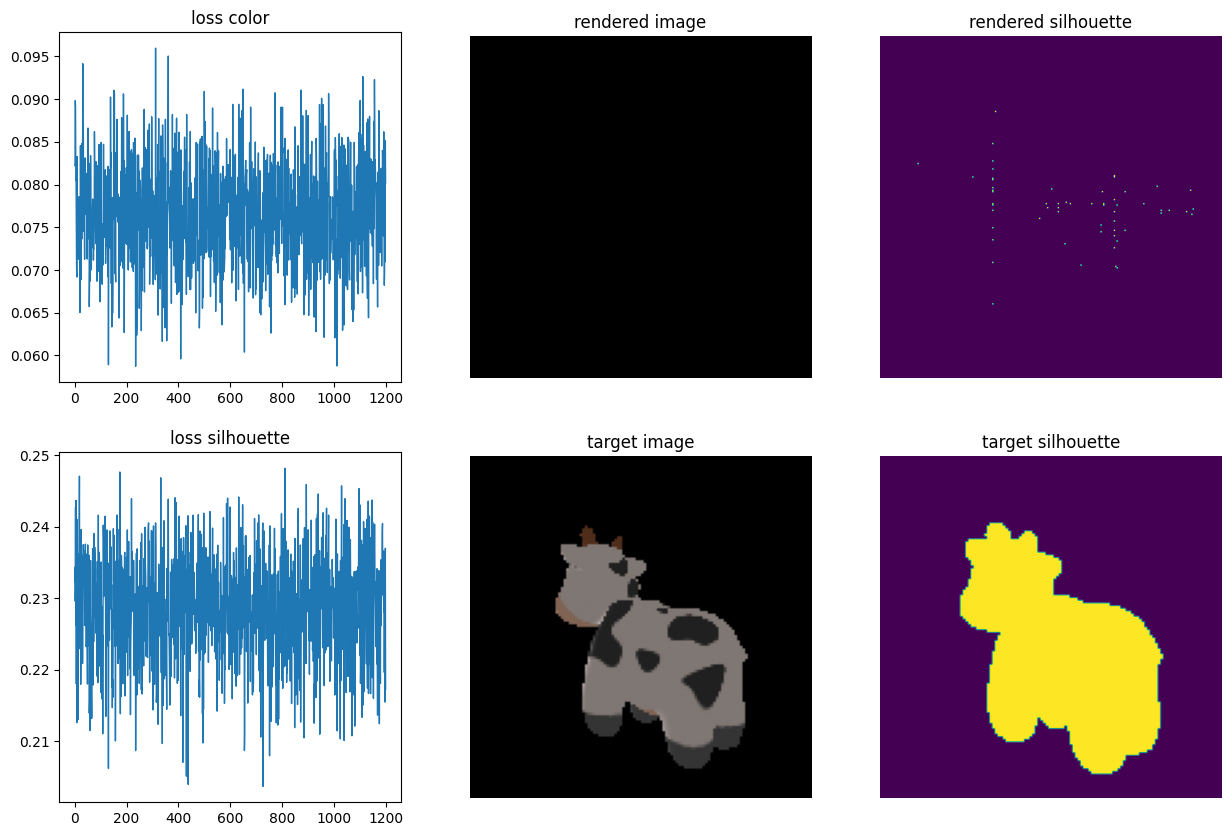

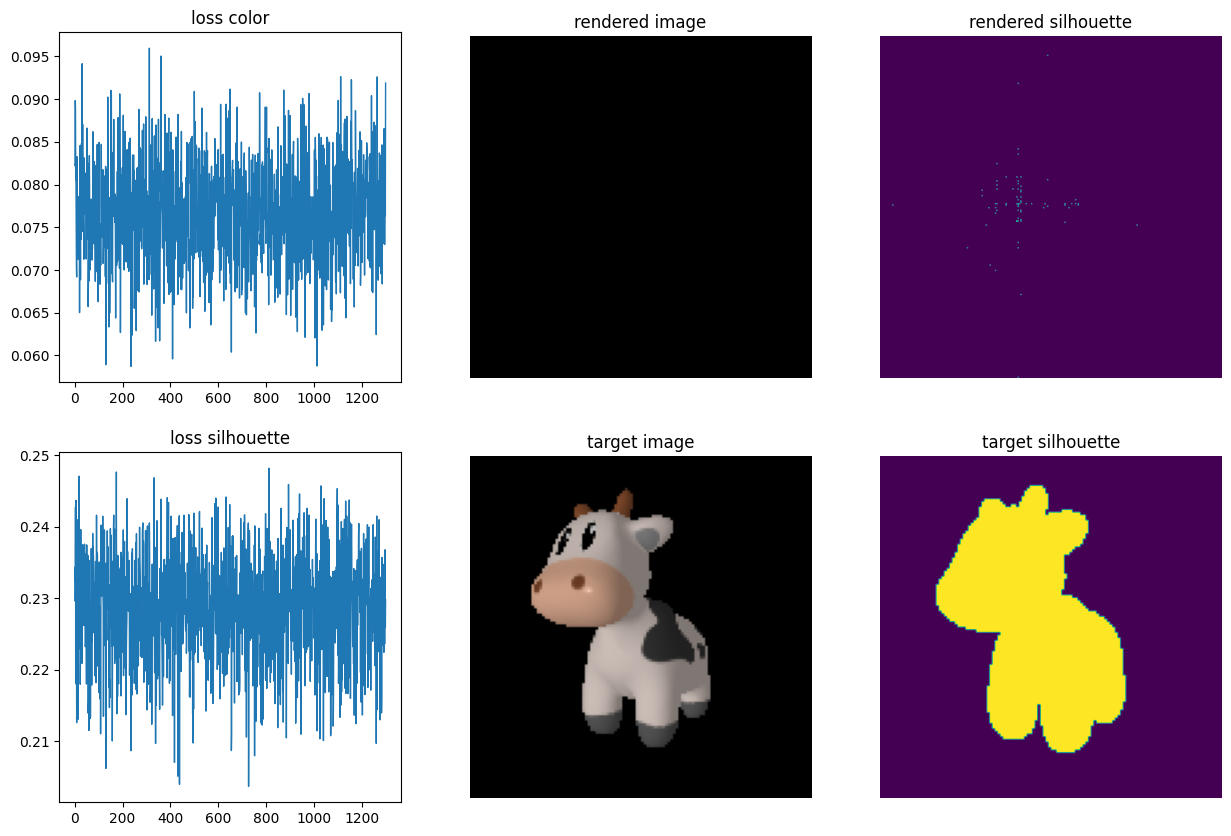

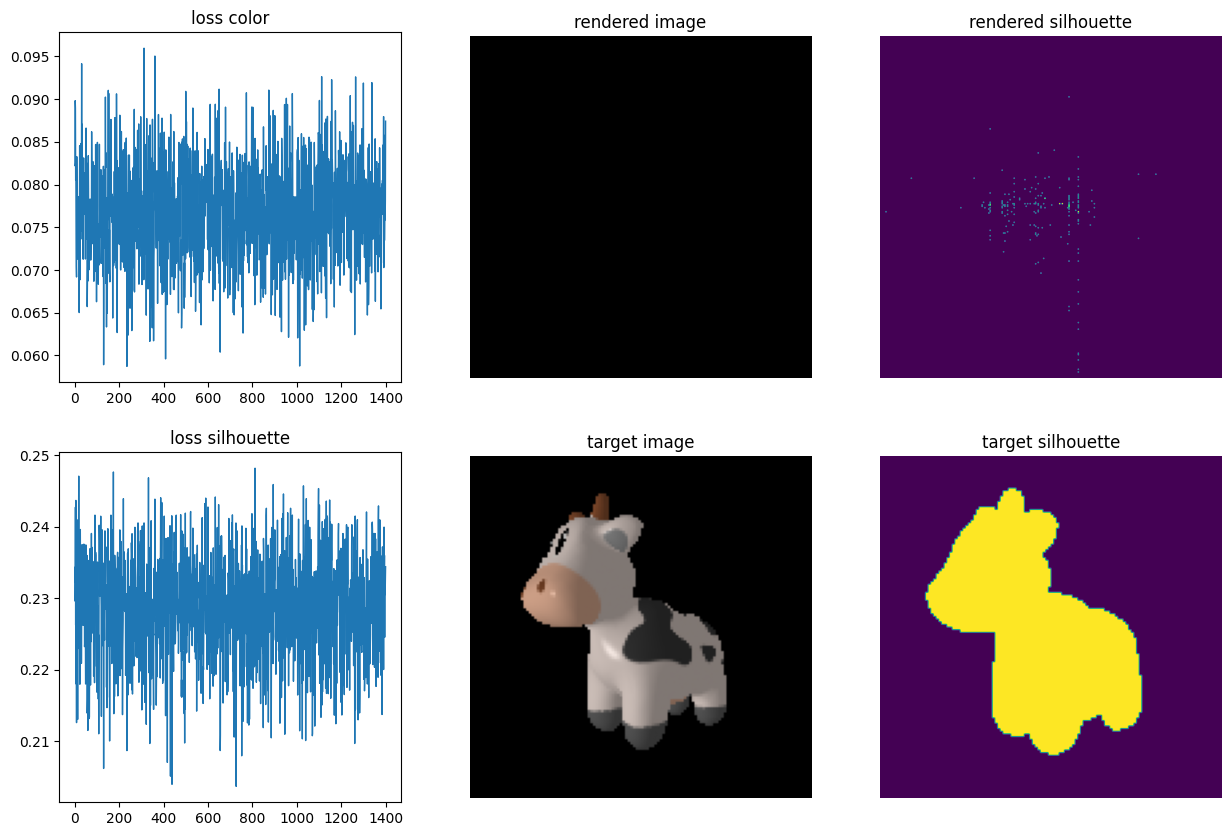

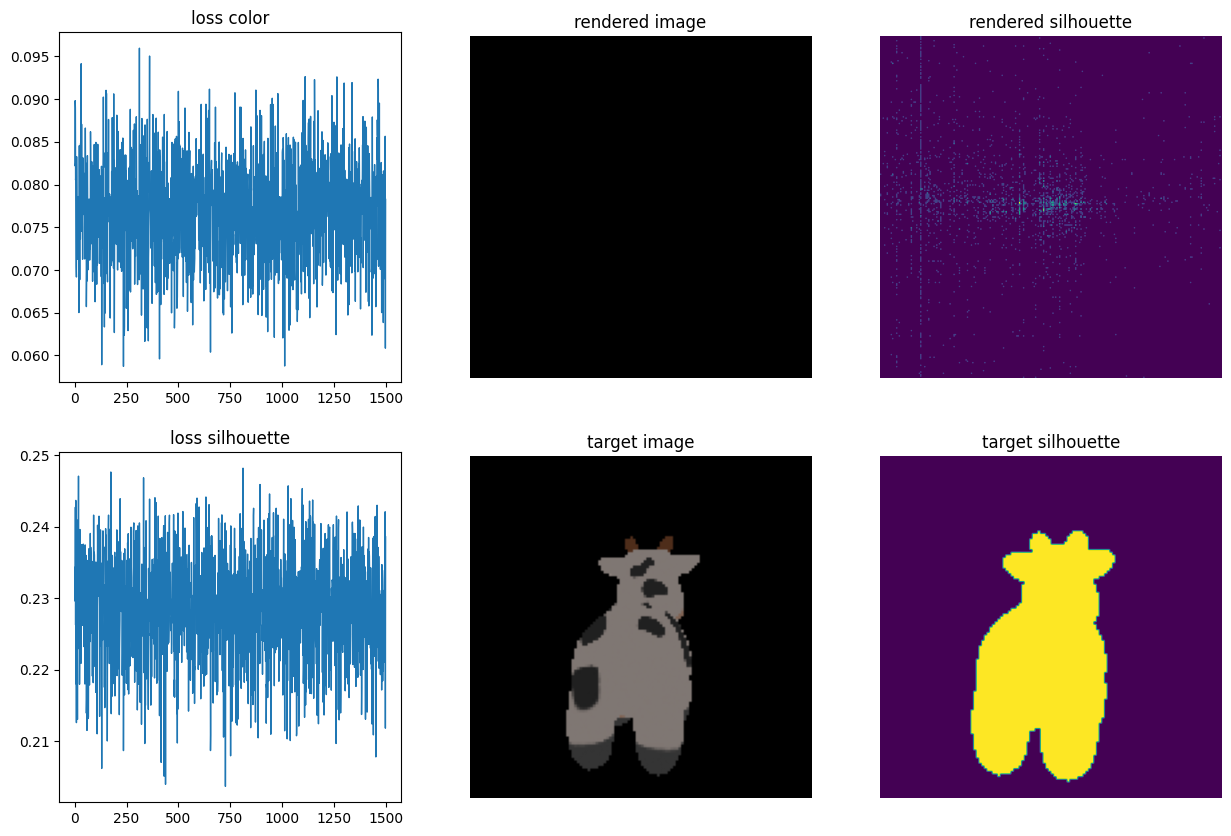

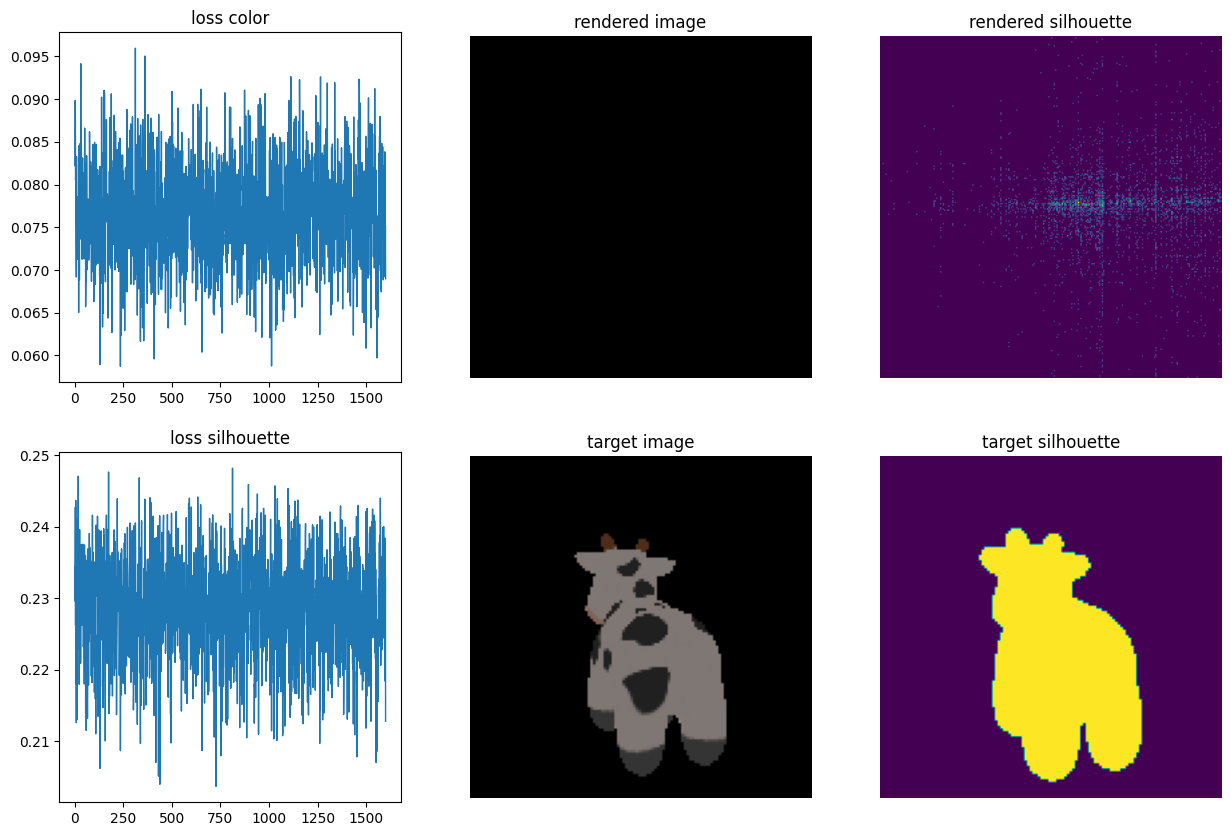

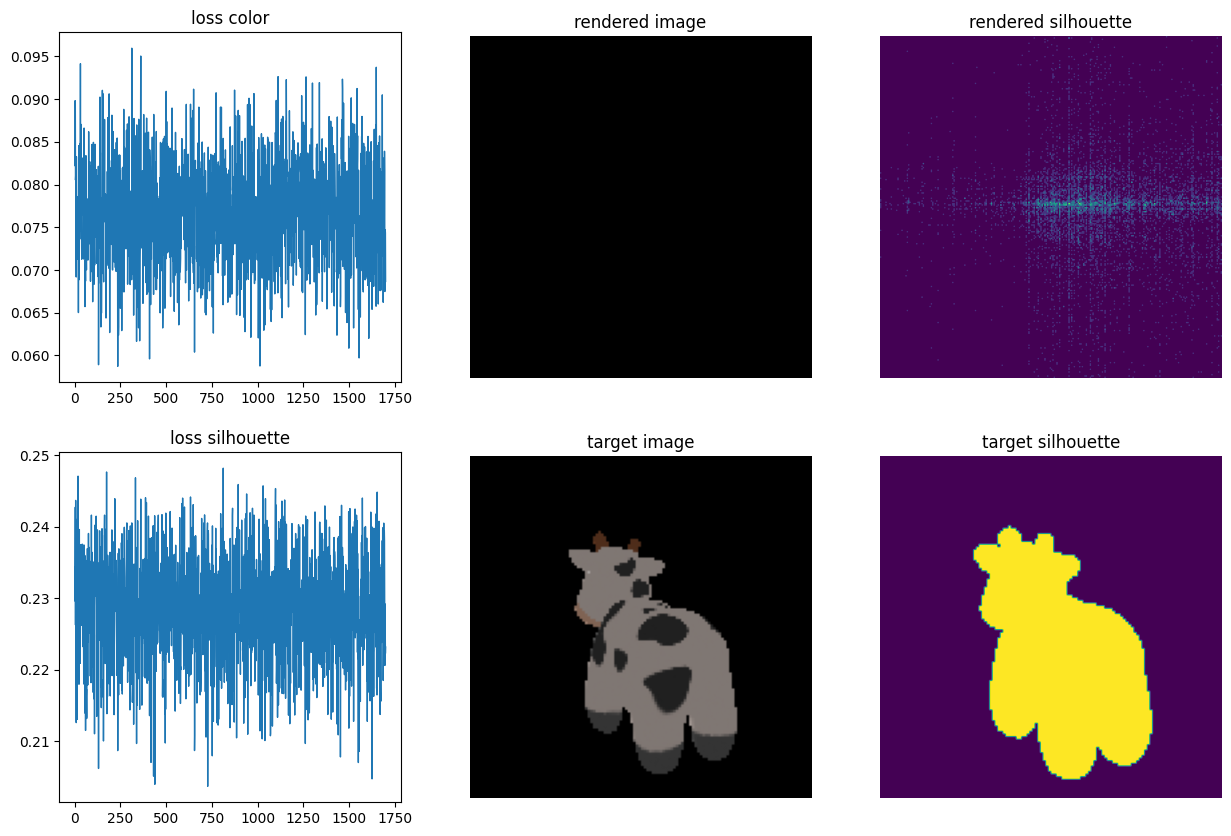

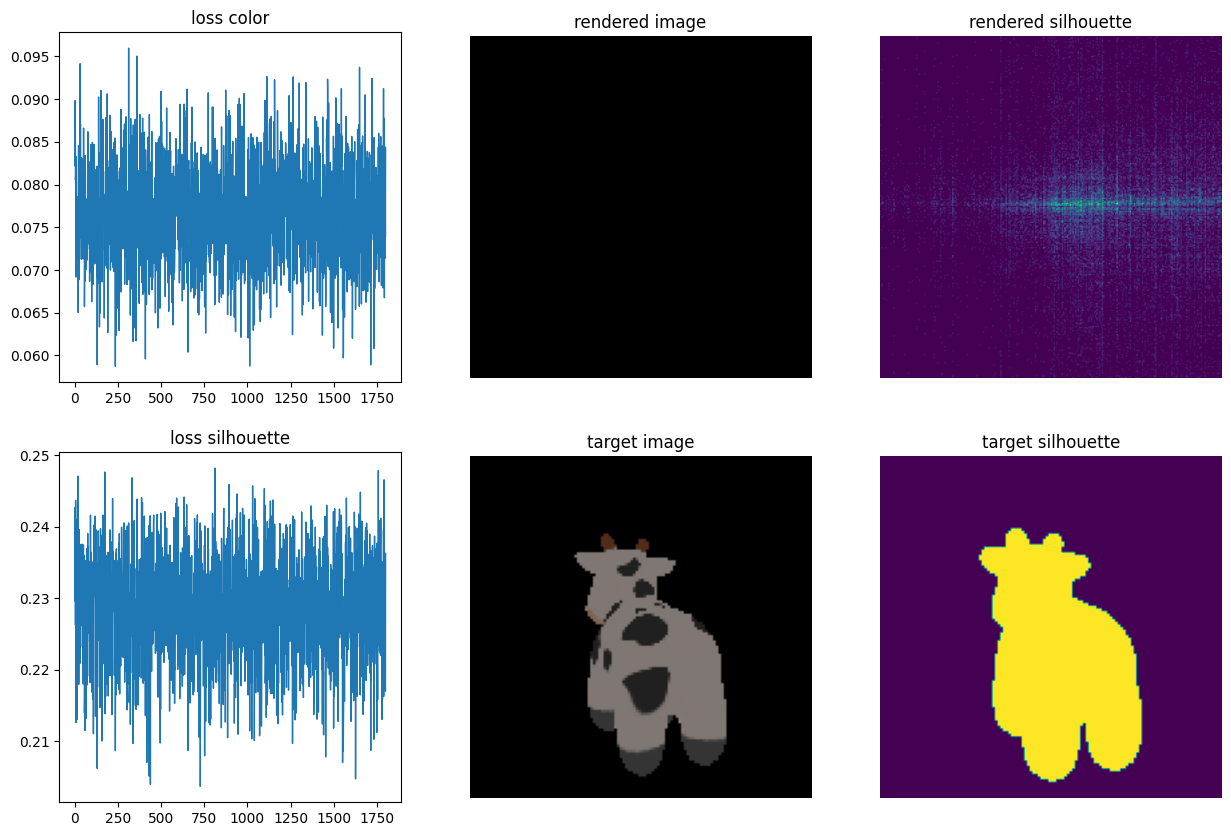

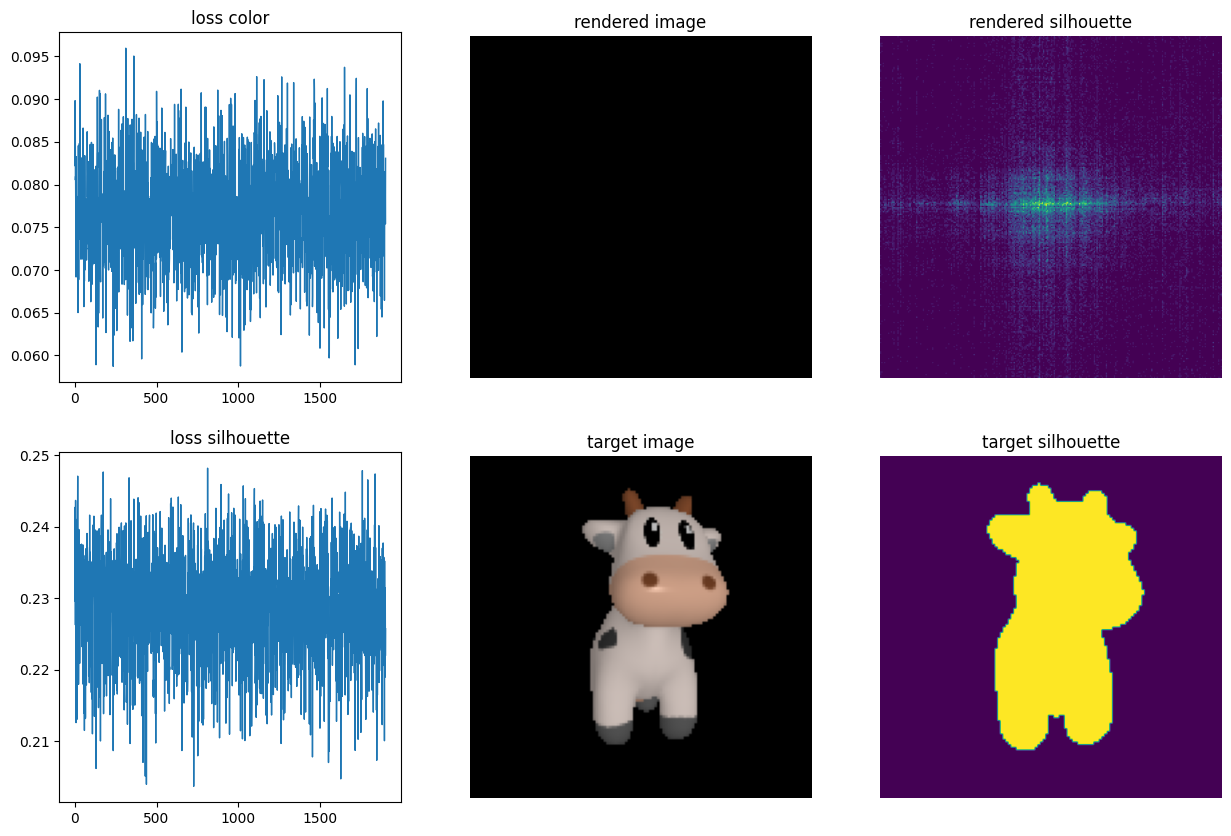

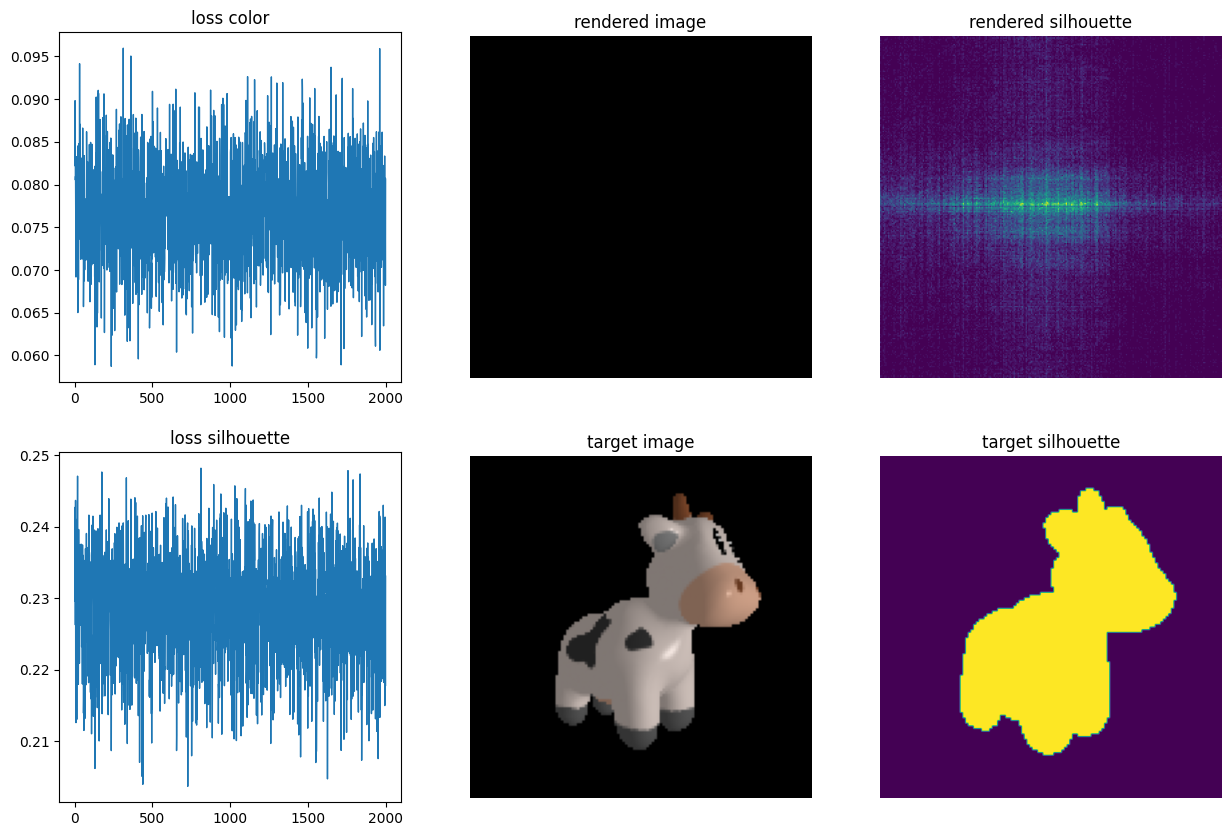

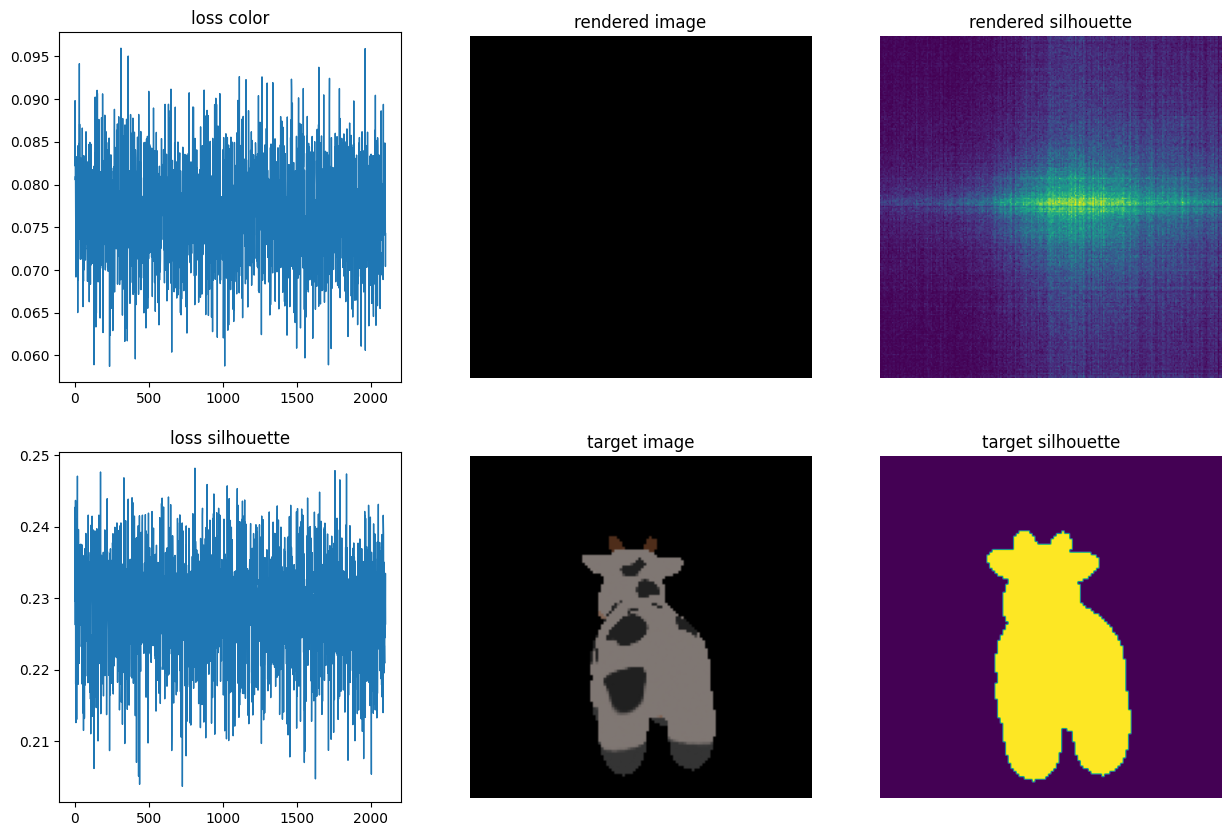

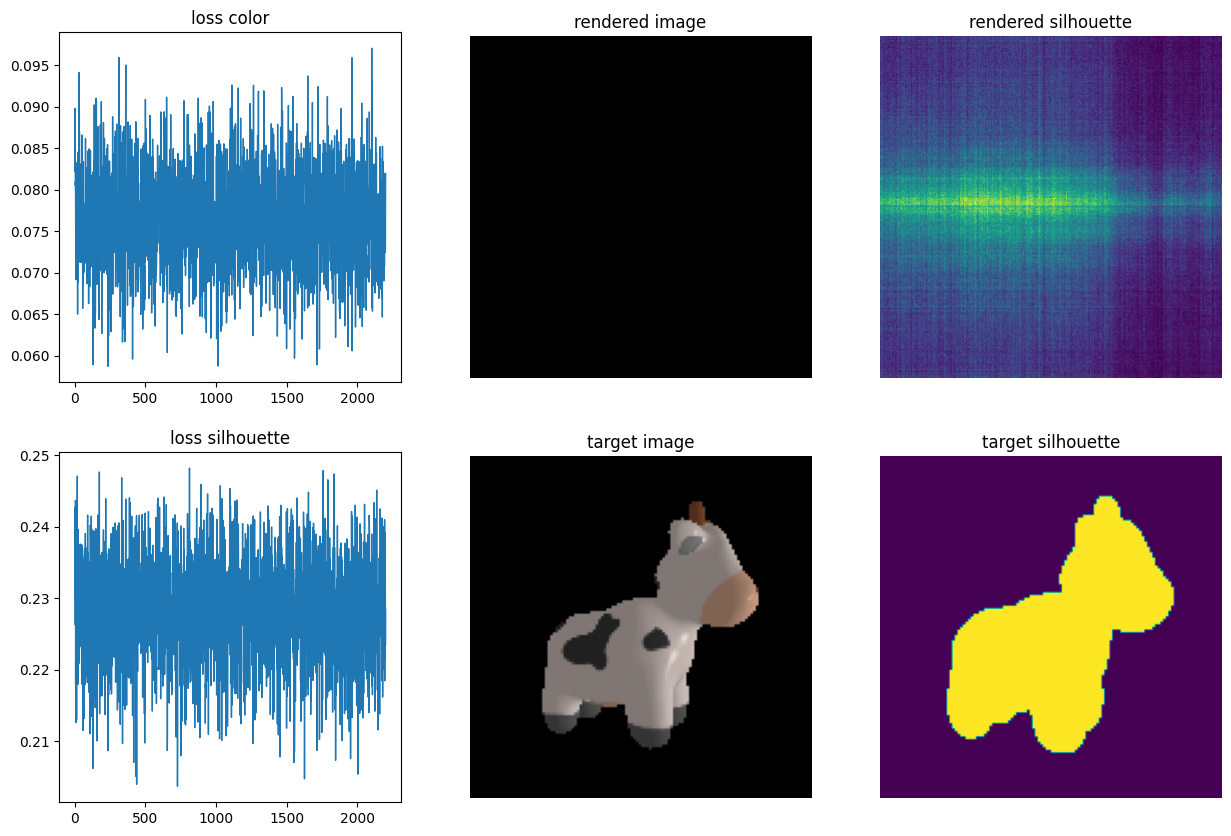

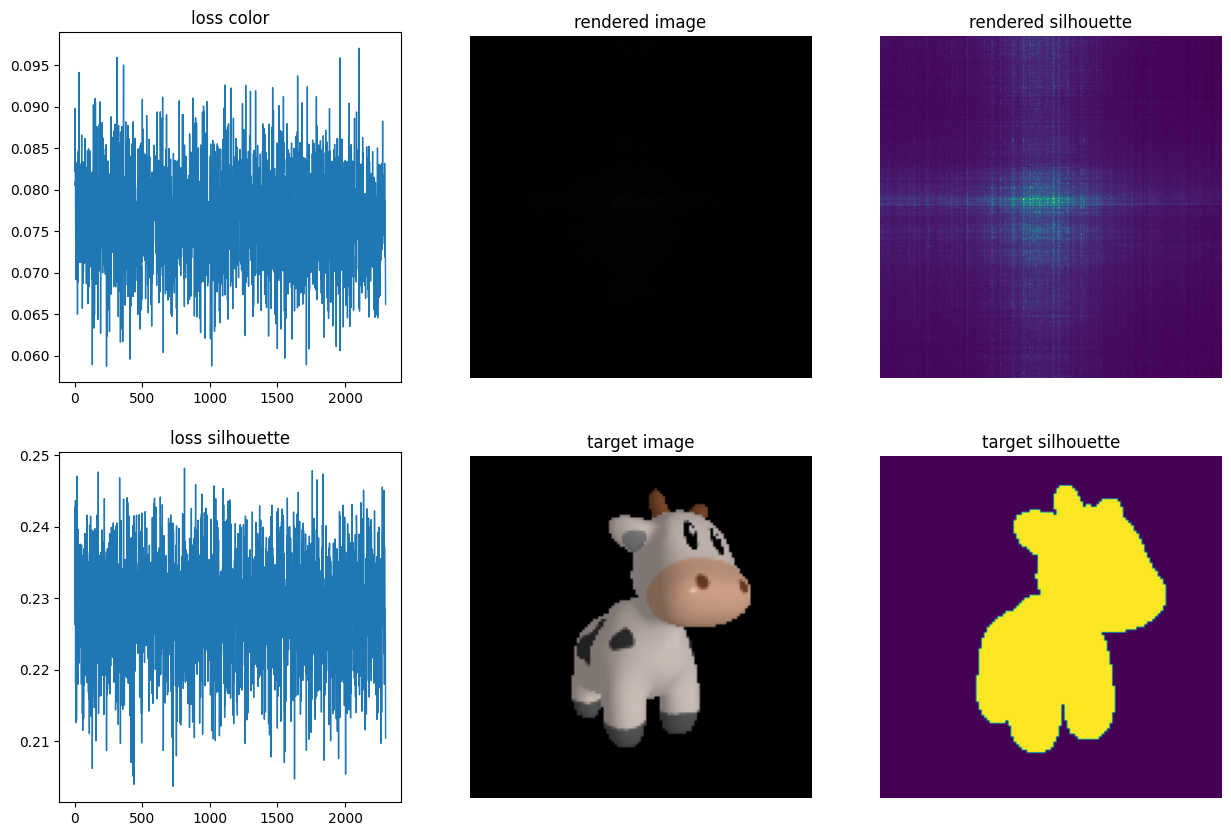

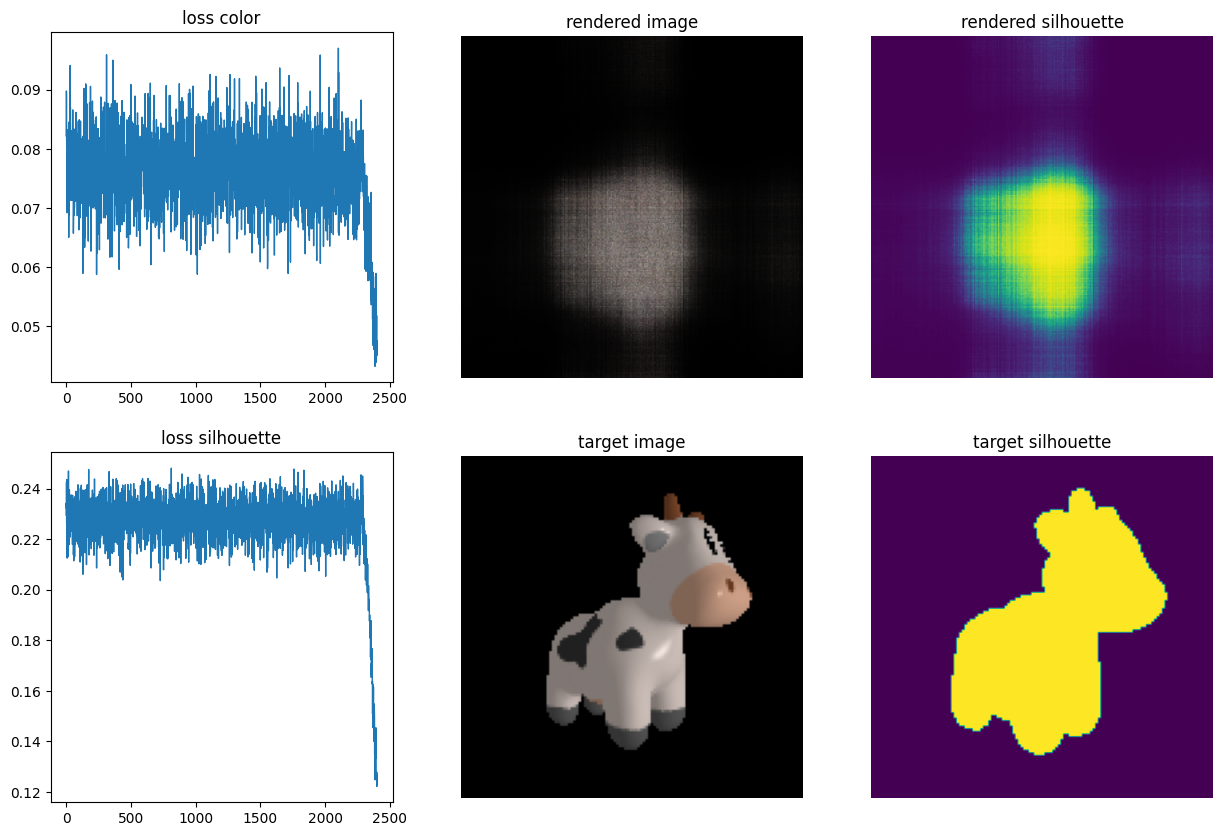

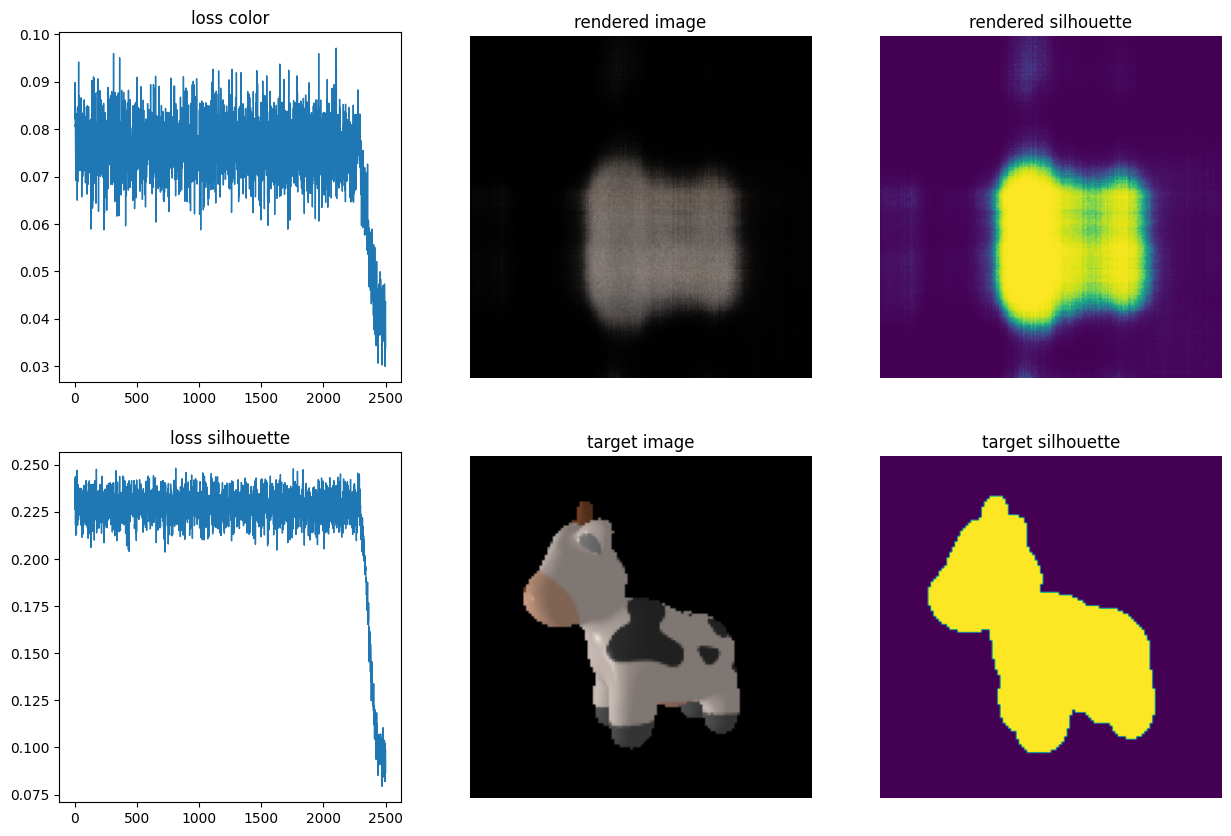

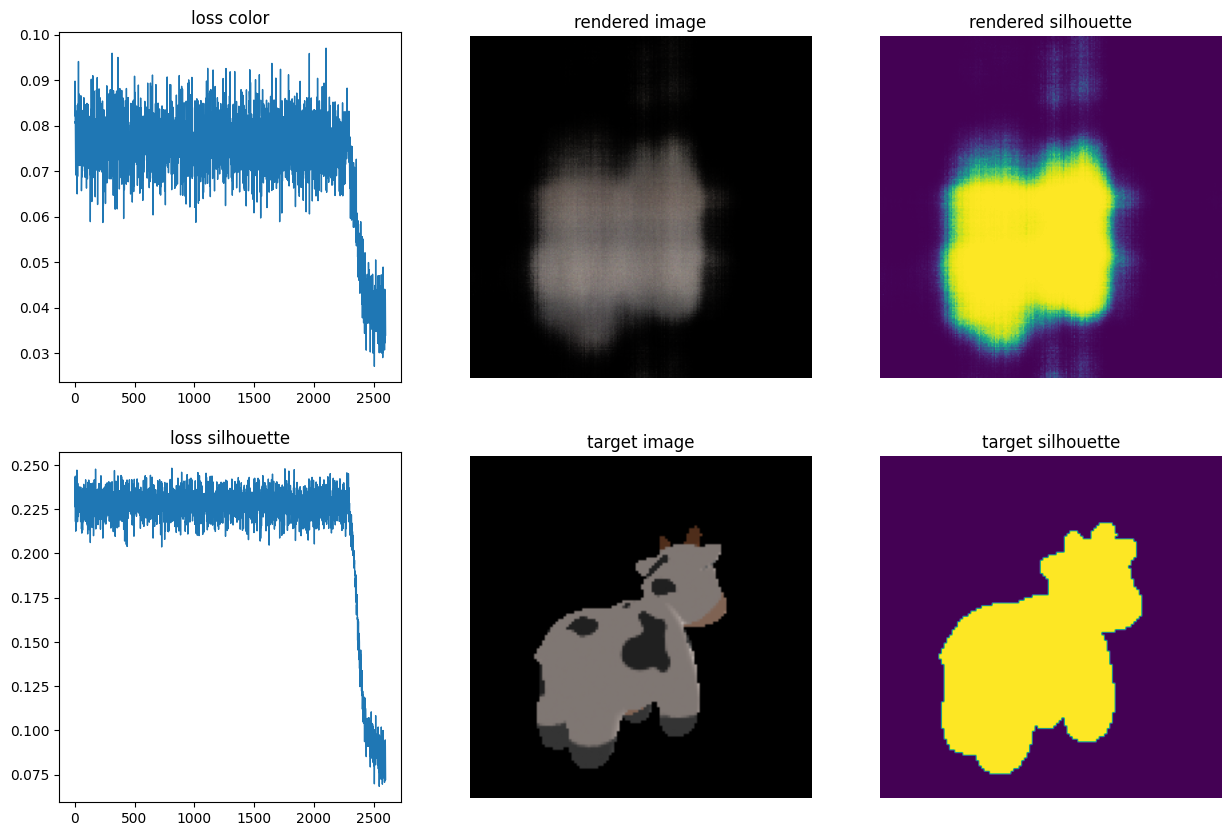

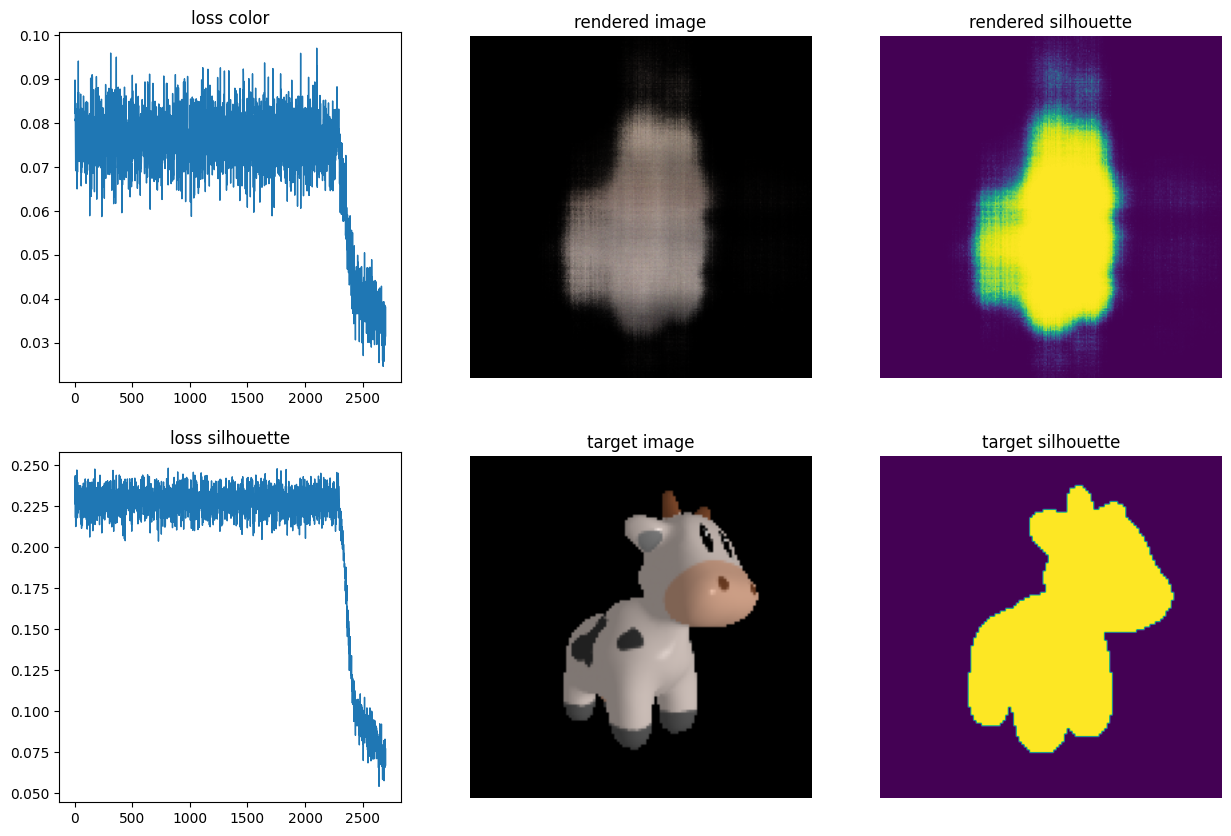

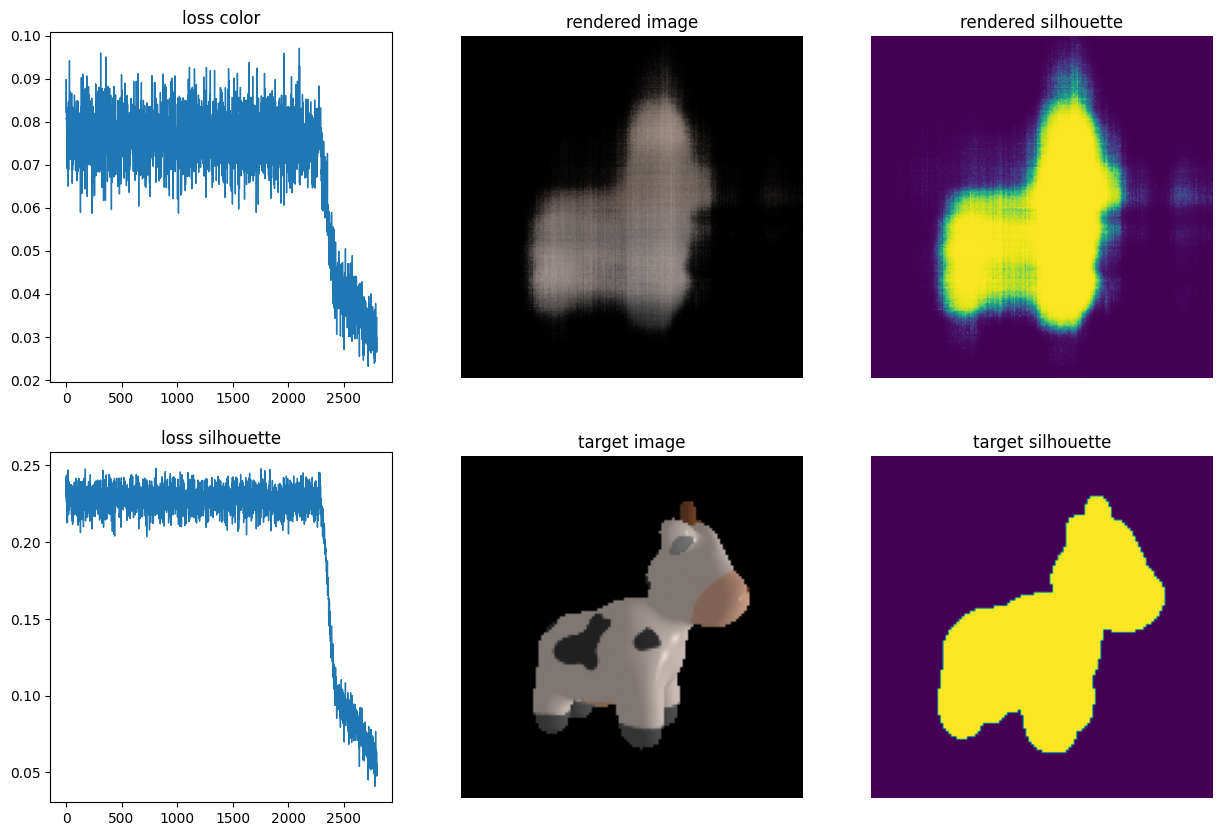

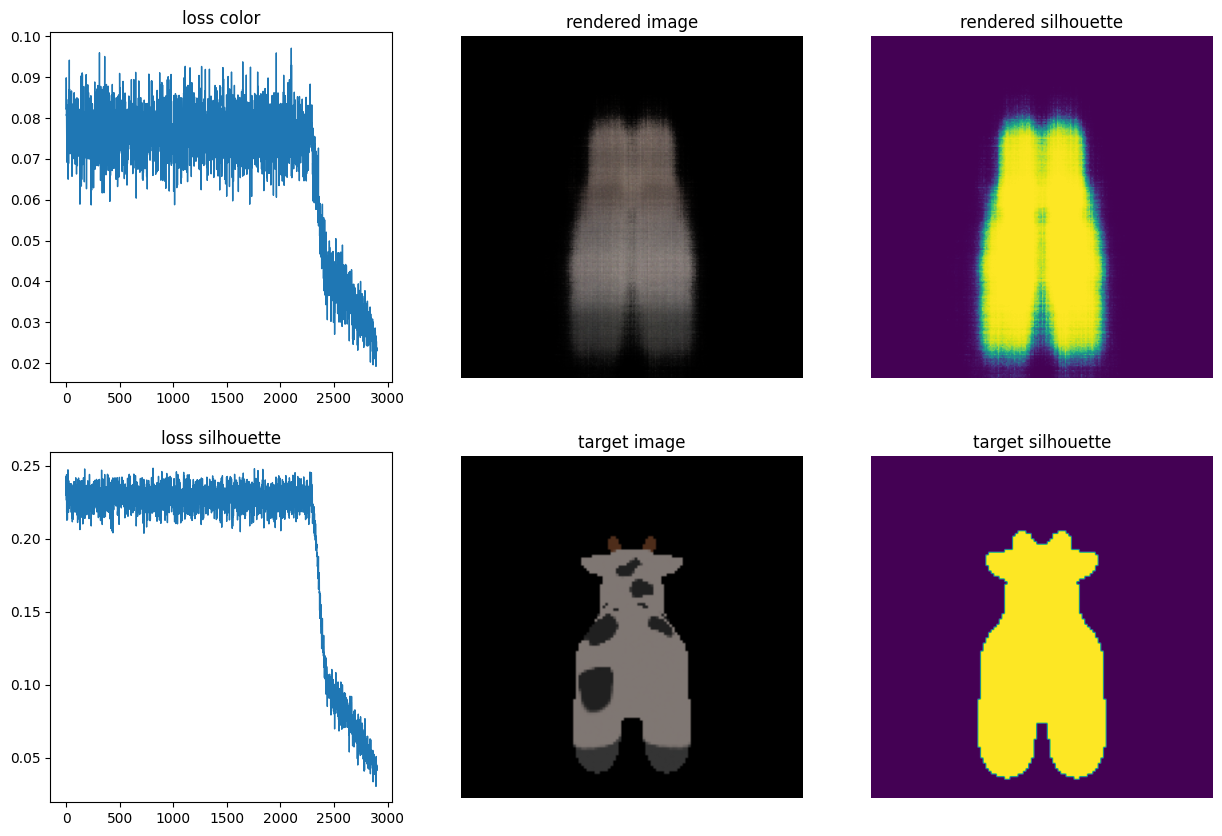

In [11]:
loss_history_color,loss_history_sil = [],[]
for iteration in range(n_iter):
    if iteration==round(n_iter*0.75):
        print('Decreasing lr 10-fold')
        optimizer = torch.optim.Adam(neural_radiance.parameters(),lr=lr*0.1)
    optimizer.zero_grad()
    batch_idx= torch.randperm(len(target_cameras))[:batch_size]
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear= target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device=device
    )

    rendered_images_silhouettes ,sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function = neural_radiance
    )
    rendered_images,rendered_silhouettes = (
        rendered_images_silhouettes.split([3,1],dim=-1)
    )
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx,...,None],
        sampled_rays.xys
    )

    sil_err = huber(
        rendered_silhouettes,
        silhouettes_at_rays,
    ).abs().mean()

    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(
        rendered_images,
        colors_at_rays,
    ).abs().mean()
    loss = color_err + sil_err
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))
    loss.backward()
    optimizer.step()
    if iteration %100==0:
        show_idx = torch.randperm(len(target_cameras))[:1]
        fig = show_full_render(
            neural_radiance,FoVPerspectiveCameras(
                R = target_cameras.R[show_idx],
                T = target_cameras.T[show_idx],
                znear = target_cameras.znear[show_idx],
                zfar = target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov = target_cameras.fov[show_idx],
                device=device
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            renderer_grid,
            loss_history_color,
            loss_history_sil
        )
    # fig.save(f'intermediate_{iteration}')
    fig.savefig(f'intermediate_{iteration}')






In [12]:

with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(
        neural_radiance,n_frames=3*5
    )
image_grid(rotating_nerf_frames.clamp(0.,1.).cpu().numpy(),rows=3,cols=5,rgb=True,fill=True)
plt.show()


TypeError: ignored